In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAPL.csv")
df = df.drop(columns='Unnamed: 0')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [ ]:
data = df.reset_index()['open']
data

,open
0,130.34
1,131.86
2,131.23
3,131.20
4,129.86
...,...
1253,313.17
1254,315.03
1255,316.68
1256,318.66


(1258,)


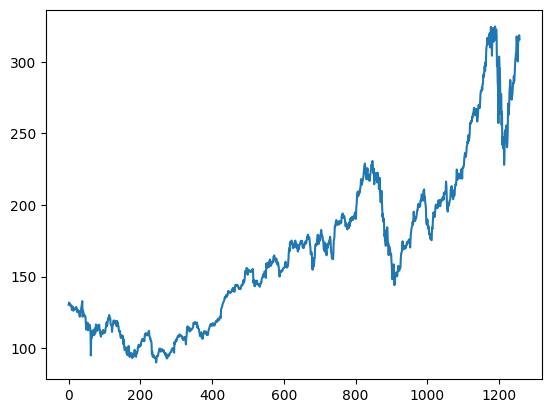

In [ ]:
print(data.shape)

plt.plot(data)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(np.array(data).reshape(-1,1))

In [ ]:
# calculate training and test sizes
training_size = int(len(data) * 0.65)
test_size = len(data) - training_size

# split the data into training and test sets
train_data = data[:training_size]
test_data = data[training_size:]

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        dataX.append(dataset[i:i + time_step, 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test ,y_test = create_dataset(test_data, time_step)

print("TrainX shape:", x_train.shape)
print("TrainY shape:", y_train.shape)
print("TestX shape:", x_test.shape)
print("TestY shape:", y_test.shape)

TrainX shape: (717, 100)
TrainY shape: (717,)
TestX shape: (341, 100)
TestY shape: (341,)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Encoder
encoder_inputs = Input(shape=(time_step, 1))
encoder_lstm1 = LSTM(50, return_sequences=True)(encoder_inputs)
encoder_lstm2 = LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_lstm1)

# encoder states which will be passed to the decoder
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None, 1))  # same shape input as the encoder
decoder_lstm1 = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
decoder_lstm2 = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm2(decoder_outputs)
decoder_dense = Dense(1)  # final output layer since we're predicting one value at a time
decoder_outputs = decoder_dense(decoder_outputs)

# model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 100, 50)        │         10,400 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, 50), (None,    │         20,200 │ lstm_4[0][0]           │
│                           │ 50), (None, 50)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, None, 50),     │         10,400 │ input_layer_3[0][0],   │
│                           │ (None, 50), (None,     │                │ lstm_5[0][1],          │
│                           │ 50)]                   │                │ lstm_5[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, None, 50),     │         20,200 │ lstm_6[0][0]           │
│                           │ (None, 50), (None,     │                │                        │
│                           │ 50)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 1)        │             51 │ lstm_7[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 61,251 (239.26 KB)

 Trainable params: 61,251 (239.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# reshape data for LSTM [samples, time steps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# for the decoder, the input data is shifted by one timestep
decoder_input_train = np.zeros_like(y_train)
decoder_input_train = np.roll(y_train, shift=1)  # shift data for teacher forcing
decoder_input_train[0] = 0  # the first element can be anything since it won't be used

decoder_input_test = np.zeros_like(y_test)
decoder_input_test = np.roll(y_test, shift=1)
decoder_input_test[0] = 0  # the first element can be anything since it won't be used

# reshape to match the input shape [samples, time steps, features]
decoder_input_train = decoder_input_train.reshape((decoder_input_train.shape[0], 1, 1))
decoder_input_test = decoder_input_test.reshape((decoder_input_test.shape[0], 1, 1))

In [ ]:
# train the model
model.fit([x_train, decoder_input_train], y_train.reshape(-1, 1, 1),
          epochs=50,
          batch_size=64,
          validation_data=([x_test, decoder_input_test], y_test.reshape(-1, 1, 1)))

# save the model
model.save('stock_price_encoder_decoder.keras')

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.0503 - val_loss: 0.0655
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0114 - val_loss: 0.0967
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0045 - val_loss: 0.0282
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 0.0103
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.6384e-04 - val_loss: 0.0107
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.1390e-04 - val_loss: 0.0111
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.7776e-04 - val_loss: 0.0105
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.8290e-04 - val_loss: 0.0098
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.9019e-04 - val_loss: 0.0115
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.9110e-04 - val_loss: 0.0110
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.9499e-04 - val_loss: 0.0109
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━

In [ ]:
# predict the next 100 days
predictions = []
last_input = x_test[-1]  # start with the last input from the test set

for _ in range(100):
    # predict the next value
    predicted_value = model.predict([last_input.reshape((1, time_step, 1)), np.zeros((1, 1, 1))])
    predictions.append(predicted_value[0, 0, 0])

    # update the input sequence by adding the predicted value and keeping the shape consistent
    last_input = np.roll(last_input, -1, axis=0) # shift values one step back
    last_input[-1, 0] = predicted_value[0, 0, 0] # replace the last value with the prediction

# print the predictions
print("Predicted stock prices for the next 100 days:", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

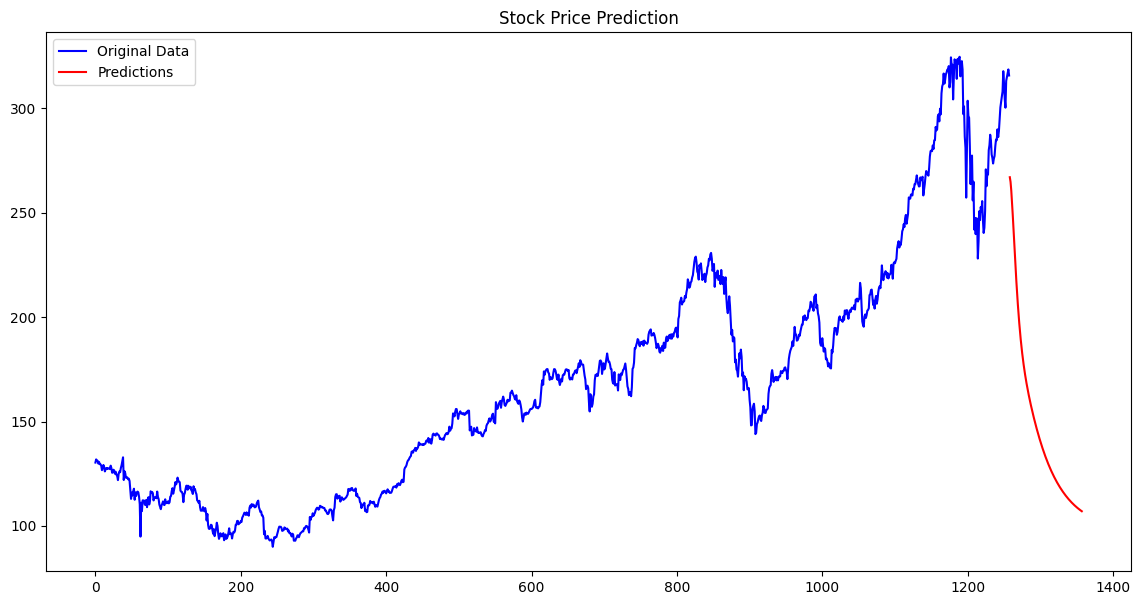

In [ ]:
# number of future predictions (e.g., 100 days)
future_days = 100

# inverse transform the original data
original_data = scaler.inverse_transform(data)

# convert predictions list to a numpy array and reshape for inverse scaling
predictions_array = np.array(predictions).reshape(-1, 1)
predictions_transformed = scaler.inverse_transform(predictions_array)

# create an array to hold the original data and null values where predictions will be
full_plot = np.full((len(original_data) + future_days, 1), np.nan)

# place the original data into the full plot array
full_plot[:len(original_data)] = original_data

# create a separate array for predictions to ensure they are distinct
pred_plot = np.full_like(full_plot, np.nan)
pred_plot[len(original_data):] = predictions_transformed

# plot the original data in blue
plt.figure(figsize=(14, 7))
plt.plot(full_plot[:len(original_data)], label='Original Data', color='blue')

# plot the predictions in red
plt.plot(pred_plot, label='Predictions', color='red')

plt.legend()
plt.title('Stock Price Prediction')
plt.show()

trail codes

In [ ]:
# reshape into 3D
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()

model.add(Input(shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam())

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0335 - val_loss: 0.0678
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 0.0068
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.2003e-04 - val_loss: 0.0043
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.5273e-04 - val_loss: 0.0038
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.3592e-04 - val_loss: 0.0043
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.7978e-04 - val_loss: 0.0038
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.5591e-04 - val_loss: 0.0035
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.0038e-04 - val_loss: 0.0035
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.8013e-04 - val_loss: 0.0034
Epoch 12/100
12/12 ━━━━━

In [ ]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(y_train, train_pred)))
print(math.sqrt(mean_squared_error(y_test, test_pred)))

140.82996750698467
234.7856399244419


Data shape: (1258, 1)
Train predictions shape: (717, 1)
Test predictions shape: (341, 1)
Test start index: 918
Test end index: 1259


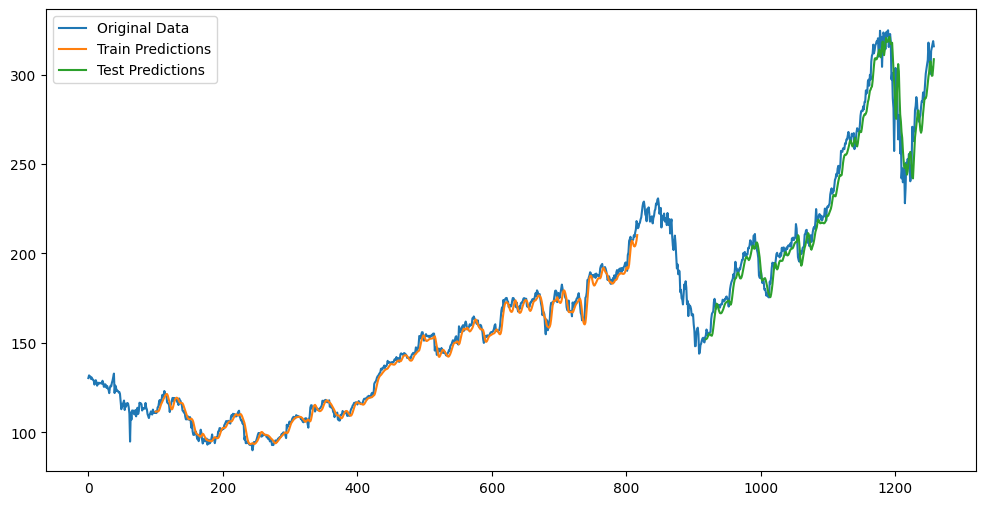

In [ ]:
# shifting train predictions for plotting
look_back = 100

train_pred_plot = np.full_like(data, np.nan)
train_pred_plot[look_back:look_back + len(train_pred), :] = train_pred

# shifting test predictions for plotting
test_start_idx = len(train_pred) + (look_back * 2) + 1
test_end_idx = test_start_idx + len(test_pred)

# debugging shapes and indices
print(f"Data shape: {data.shape}")
print(f"Train predictions shape: {train_pred.shape}")
print(f"Test predictions shape: {test_pred.shape}")
print(f"Test start index: {test_start_idx}")
print(f"Test end index: {test_end_idx}")

# ensure the end index does not exceed the length of the data
if test_end_idx > len(data):
    test_end_idx = len(data)

# correcting the length of test_pred if it exceeds the bounds
test_pred_plot = np.full_like(data, np.nan)
test_pred_plot[test_start_idx:test_start_idx + len(test_pred), :] = test_pred[:len(data) - test_start_idx, :]

# plot the original data, train predictions, and test predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data), label='Original Data')
plt.plot(train_pred_plot, label='Train Predictions')
plt.plot(test_pred_plot, label='Test Predictions')
plt.legend()
plt.show()

In [ ]:
len(test_data)

441

In [ ]:
x_input = test_data[341:].reshape(1, -1)
print("x_input shape:", x_input.shape)

# use the last 100 values from x_input as the initial input for predictions
new_input = x_input[0][-100:]
new_input = new_input.reshape((1, 100, 1))
print("New input shape for predictions:", new_input.shape)

x_input shape: (1, 100)
New input shape for predictions: (1, 100, 1)


In [ ]:
next_50_days_predictions = []

# predict for the next 10 days
for _ in range(50):
    pred = model.predict(new_input)
    next_50_days_predictions.append(pred[0, 0])
    new_input = np.append(new_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

print("Predictions for the next 10 days:", next_50_days_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [ ]:
next_50_days_predictions = np.array(next_50_days_predictions).reshape(-1, 1)
next_50_days_predictions = scaler.inverse_transform(next_50_days_predictions)
print("Scaled predictions for the next 50 days:", next_50_days_predictions)

Scaled predictions for the next 50 days: [[314.1063 ]
 [313.04593]
 [311.06738]
 [308.9471 ]
 [307.01627]
 [305.444  ]
 [304.32138]
 [303.67062]
 [303.45044]
 [303.57047]
 [303.9107 ]
 [304.34158]
 [304.74255]
 [305.01648]
 [305.09915]
 [304.96295]
 [304.6149 ]
 [304.0905 ]
 [303.4443 ]
 [302.73944]
 [302.03757]
 [301.39078]
 [300.836  ]
 [300.3925 ]
 [300.06207]
 [299.8314 ]
 [299.67645]
 [299.5671 ]
 [299.472  ]
 [299.36295]
 [299.21823]
 [299.02426]
 [298.7763 ]
 [298.47766]
 [298.13794]
 [297.7708 ]
 [297.39163]
 [297.01492]
 [296.6529 ]
 [296.31378]
 [296.0017 ]
 [295.71655]
 [295.4547 ]
 [295.21014]
 [294.9754 ]
 [294.743  ]
 [294.50616]
 [294.2599 ]
 [294.001  ]
 [293.72858]]


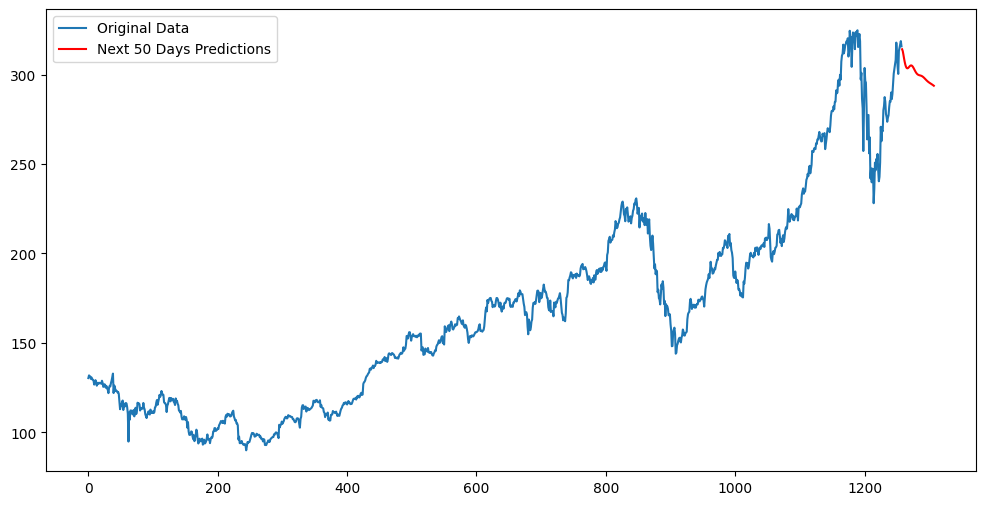

In [ ]:
# plot the original data
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data), label='Original Data')
all_data_with_predictions = np.append(data, next_50_days_predictions)

# plot the new predictions
plt.plot(range(len(data), len(data) + 50), next_50_days_predictions, label='Next 50 Days Predictions', color='red')
plt.legend()
plt.show()